In [ ]:
# ============================================================================
# ENHANCED TIMED AUTOMATA NETWORK SCHEDULER WITH REAL-TIME ANIMATION
# COMPLETE AND CORRECTED VERSION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import defaultdict, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import joblib

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, Video, display
import matplotlib.patches as mpatches
from google.colab import files
import io

print("Libraries installed and imported successfully!")

# ============================================================================
# PACKET DATA STRUCTURE
# ============================================================================

@dataclass
class Packet:
    arrival_time: float
    packet_type: str
    size: int
    protocol: str
    src_port: int = 0
    dst_port: int = 0
    deadline: float = float('inf')
    priority_score: float = 0.0
    processing_start_time: float = 0.0
    processing_end_time: float = 0.0
    state: str = 'waiting'

# ============================================================================
# TIMED AUTOMATON SCHEDULER
# ============================================================================

class EnhancedTimedAutomaton:
    def __init__(self, max_queue_size: int = 10000):
        self.states = ["Idle", "SendUrgent", "SendNormal", "SendLow", "Preempted", "BufferFull"]
        self.current_state = "Idle"
        self.clocks = {"x": 0.0, "deadline": 0.0, "queue_time": 0.0, "idle_time": 0.0}
        self.urgent_queue = deque()
        self.normal_queue = deque()
        self.low_queue = deque()
        self.max_queue_size = max_queue_size
        self.current_packet: Optional[Packet] = None
        self.preempted_packet: Optional[Packet] = None
        self.transitions = self._define_transitions()
        self.invariants = {
            "Idle": lambda c: True,
            "SendUrgent": lambda c: c["x"] <= 10.0,
            "SendNormal": lambda c: c["x"] <= 30.0,
            "SendLow": lambda c: c["x"] <= 60.0,
            "Preempted": lambda c: c["queue_time"] <= 100.0,
            "BufferFull": lambda c: c["idle_time"] <= 5.0
        }
        self.statistics = {
            'packets_processed': 0,
            'packets_dropped': 0,
            'deadline_misses': 0,
            'preemptions': 0,
            'buffer_overflows': 0,
            'waiting_times': {'urgent': [], 'normal': [], 'low': []},
            'processing_times': {'urgent': [], 'normal': [], 'low': []},
            'queue_lengths': [],
            'throughput_over_time': [],
            'state_durations': defaultdict(float),
            'state_history': []
        }
        self.log = []
        self.violations = 0
        self.start_time = 0.0
        self.last_state_change = 0.0
        self.animation_snapshots = []

    def _define_transitions(self):
        return [
            ("Idle", "SendUrgent", "process_urgent", lambda c, p: len(self.urgent_queue) > 0, ["x"]),
            ("Idle", "SendNormal", "process_normal", lambda c, p: len(self.normal_queue) > 0 and len(self.urgent_queue) == 0, ["x"]),
            ("Idle", "SendLow", "process_low", lambda c, p: len(self.low_queue) > 0 and len(self.urgent_queue) == 0 and len(self.normal_queue) == 0, ["x"]),
            ("SendUrgent", "Idle", "complete", lambda c, p: c["x"] >= 0.01, ["x", "deadline", "queue_time"]),
            ("SendNormal", "Idle", "complete", lambda c, p: c["x"] >= 0.02, ["x", "deadline", "queue_time"]),
            ("SendLow", "Idle", "complete", lambda c, p: c["x"] >= 0.05, ["x", "deadline", "queue_time"]),
            ("SendNormal", "Preempted", "preempt", lambda c, p: len(self.urgent_queue) > 0, []),
            ("SendLow", "Preempted", "preempt", lambda c, p: len(self.urgent_queue) > 0 or len(self.normal_queue) > 0, []),
            ("Preempted", "SendUrgent", "resume_urgent", lambda c, p: len(self.urgent_queue) > 0, ["x"]),
            ("Preempted", "SendNormal", "resume_normal", lambda c, p: len(self.urgent_queue) == 0 and self.preempted_packet and self.preempted_packet.packet_type == "normal", []),
            ("Preempted", "SendLow", "resume_low", lambda c, p: len(self.urgent_queue) == 0 and len(self.normal_queue) == 0 and self.preempted_packet and self.preempted_packet.packet_type == "low", []),
            ("Idle", "BufferFull", "overflow", lambda c, p: self._total_queue_size() >= self.max_queue_size, []),
            ("BufferFull", "Idle", "clear_buffer", lambda c, p: c["idle_time"] >= 0.5, ["idle_time"]),
        ]

    def _total_queue_size(self) -> int:
        return len(self.urgent_queue) + len(self.normal_queue) + len(self.low_queue)

    def add_packet(self, packet: Packet) -> bool:
        if self._total_queue_size() >= self.max_queue_size:
            self.statistics['packets_dropped'] += 1
            self.statistics['buffer_overflows'] += 1
            packet.state = 'dropped'
            self.log.append(f"Packet dropped (overflow) at {packet.arrival_time}")
            return False
        packet.state = 'waiting'
        if packet.packet_type == "urgent":
            self.urgent_queue.append(packet)
        elif packet.packet_type == "normal":
            self.normal_queue.append(packet)
        else:
            self.low_queue.append(packet)
        self.log.append(f"Packet queued: {packet.packet_type} at {packet.arrival_time}")
        return True

    def capture_snapshot(self, current_time: float):
        self.animation_snapshots.append({
            'time': current_time,
            'state': self.current_state,
            'urgent_queue_len': len(self.urgent_queue),
            'normal_queue_len': len(self.normal_queue),
            'low_queue_len': len(self.low_queue),
            'current_packet_type': self.current_packet.packet_type if self.current_packet else None,
            'packets_processed': self.statistics['packets_processed'],
            'packets_dropped': self.statistics['packets_dropped']
        })

    def advance_time(self, delta: float, current_time: float = 0.0) -> bool:
        self.statistics['state_durations'][self.current_state] += delta
        self.clocks = {k: v + delta for k, v in self.clocks.items()}
        if not self.animation_snapshots or current_time - self.animation_snapshots[-1]['time'] >= 0.01:
            self.capture_snapshot(current_time)
        if not self.invariants[self.current_state](self.clocks):
            self.violations += 1
            self.log.append(f"Invariant violation in {self.current_state} at {self.clocks['x']}")
            if self.current_packet:
                self.statistics['deadline_misses'] += 1
                self.log.append(f"Deadline missed for {self.current_packet.packet_type}")
            return False
        self.statistics['queue_lengths'].append({
            'time': current_time,
            'urgent': len(self.urgent_queue),
            'normal': len(self.normal_queue),
            'low': len(self.low_queue),
            'total': self._total_queue_size()
        })
        return True

    def take_transition(self, current_time: float) -> bool:
        for src, dst, event, guard, resets in self.transitions:
            if src == self.current_state and guard(self.clocks, None):
                if event == "preempt":
                    self._handle_preemption()
                    self.statistics['preemptions'] += 1
                elif event.startswith("process_"):
                    self._start_processing(current_time)
                elif event == "complete":
                    self._complete_processing(current_time)
                elif event.startswith("resume_"):
                    self._resume_processing()
                for clock in resets:
                    self.clocks[clock] = 0.0
                self.current_state = dst
                self.statistics['state_history'].append({
                    'time': current_time,
                    'from_state': src,
                    'to_state': dst,
                    'event': event
                })
                self.log.append(f"Transition: {src} -> {dst} ({event}) at {current_time}")
                return True
        return False

    def _handle_preemption(self):
        if self.current_packet:
            self.current_packet.state = 'preempted'
            self.preempted_packet = self.current_packet
            self.log.append(f"Preempted {self.current_packet.packet_type}")

    def _start_processing(self, current_time: float):
        if len(self.urgent_queue) > 0:
            self.current_packet = self.urgent_queue.popleft()
        elif len(self.normal_queue) > 0:
            self.current_packet = self.normal_queue.popleft()
        elif len(self.low_queue) > 0:
            self.current_packet = self.low_queue.popleft()
        if self.current_packet:
            self.current_packet.state = 'processing'
            self.current_packet.processing_start_time = current_time
            wait_time = current_time - self.current_packet.arrival_time
            self.statistics['waiting_times'][self.current_packet.packet_type].append(max(0, wait_time))

    def _complete_processing(self, current_time: float):
        if self.current_packet:
            self.current_packet.state = 'completed'
            self.current_packet.processing_end_time = current_time
            processing_time = self.clocks['x']
            self.statistics['processing_times'][self.current_packet.packet_type].append(processing_time)
            self.statistics['packets_processed'] += 1
            self.log.append(f"Completed {self.current_packet.packet_type} in {processing_time}s")
            self.current_packet = None

    def _resume_processing(self):
        if self.preempted_packet:
            self.current_packet = self.preempted_packet
            self.current_packet.state = 'processing'
            self.preempted_packet = None
            self.log.append(f"Resumed {self.current_packet.packet_type}")

    def _get_processing_time(self, packet_type: str) -> float:
        return {"urgent": 0.01, "normal": 0.02, "low": 0.05}.get(packet_type, 0.02)

# ============================================================================
# RULE-BASED PACKET CLASSIFIER
# ============================================================================

class EnhancedPacketClassifier:
    def __init__(self):
        self.protocol_priorities = {
            'ICMP': 'urgent', 'ICMPv6': 'urgent', 'ARP': 'urgent', 'RARP': 'urgent',
            'DHCP': 'urgent', 'DNS': 'urgent', 'NBNS': 'urgent', 'NTP': 'urgent',
            'SNMP': 'urgent', 'TCP': 'normal', 'UDP': 'normal', 'HTTP': 'normal',
            'HTTPS': 'normal', 'TLSv1.2': 'normal', 'TLSv1.3': 'normal', 'SSH': 'normal',
            'TELNET': 'normal', 'BROWSER': 'normal', 'OCSP': 'normal', 'FTP': 'low',
            'SMTP': 'low', 'POP3': 'low', 'IMAP': 'low', 'OTHER': 'normal'
        }

    def classify_packet_priority(self, protocol: str, size: int) -> str:
        priority = self.protocol_priorities.get(protocol.upper().strip(), 'normal')
        if size > 1500 and priority == 'normal':
            priority = 'low'
        elif size < 100 and priority == 'normal':
            priority = 'urgent'
        return priority

# ============================================================================
# ML MODEL TRAINING
# ============================================================================

class DeadlinePredictorTrainer:
    def __init__(self):
        self.model = None
        self.feature_encoders = {}
        self.features = ['Protocol', 'Length', 'Source_Port', 'Dest_Port']

    def train(self, csv_path: str):
        print("="*70)
        print("Starting ML Model Training for Dynamic Deadlines...")
        print("="*70)
        try:
            df = pd.read_csv(csv_path)
            df.columns = df.columns.str.strip().str.replace('"', '')
            print(f"Loaded {len(df)} records for training.")
        except FileNotFoundError:
            print(f"Error: The file '{csv_path}' was not found. Please upload it first.")
            return

        df['Info'] = df['Info'].astype(str)
        df['Source_Port'] = df['Info'].str.extract(r'(\d+)\s*>').fillna(0).astype(int)
        df['Dest_Port'] = df['Info'].str.extract(r'>\s*(\d+)').fillna(0).astype(int)
        print("Engineered features: Source_Port, Dest_Port.")

        def create_target_deadline(row):
            protocol = str(row['Protocol']).upper()
            size = int(row['Length'])
            base_deadline = 15.0
            if protocol in ['ICMP', 'DNS', 'ARP', 'NTP']:
                base_deadline = 5.0
            elif protocol in ['FTP', 'SMTP']:
                base_deadline = 30.0
            size_factor = 1 - (min(size, 1500) / 1500)
            return base_deadline * (1 + size_factor)
        df['predicted_deadline'] = df.apply(create_target_deadline, axis=1)
        print("Created target 'predicted_deadline' variable for training.")

        self.feature_encoders['Protocol'] = LabelEncoder()
        df['Protocol'] = self.feature_encoders['Protocol'].fit_transform(df['Protocol'].astype(str))

        X = df[self.features]
        y = df['predicted_deadline']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print("Training the Gradient Boosting Regressor model...")
        self.model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        self.model.fit(X_train, y_train)
        print("Model training complete!")

        y_pred = self.model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        print(f"\nModel Root Mean Squared Error (RMSE): {rmse:.4f} seconds")

        joblib.dump(self.model, 'deadline_predictor_model.pkl')
        joblib.dump(self.feature_encoders, 'deadline_feature_encoders.pkl')
        print("Deadline prediction model saved successfully to disk.")
        print("="*70)

def run_training():
    print("Please upload your Wireshark CSV data file for TRAINING.")
    uploaded = files.upload()
    if not uploaded:
        print("No file uploaded. Training aborted.")
        return
    csv_file_path = list(uploaded.keys())[0]
    trainer = DeadlinePredictorTrainer()
    trainer.train(csv_file_path)

# ============================================================================
# ML DEADLINE PREDICTOR
# ============================================================================

class DeadlinePredictor:
    def __init__(self, model_path, encoders_path):
        print("\n" + "="*70)
        print("Loading trained Deadline Predictor ML model...")
        self.model = joblib.load(model_path)
        self.feature_encoders = joblib.load(encoders_path)
        self.features = ['Protocol', 'Length', 'Source_Port', 'Dest_Port']
        print("Model loaded successfully. Ready to predict dynamic deadlines.")
        print("="*70)

    def predict(self, protocol: str, size: int, info: str) -> float:
        data = {'Protocol': protocol, 'Length': size}
        data['Source_Port'] = int(pd.Series(info).str.extract(r'(\d+)\s*>').fillna(0).iloc[0])
        data['Dest_Port'] = int(pd.Series(info).str.extract(r'>\s*(\d+)').fillna(0).iloc[0])
        df = pd.DataFrame([data])
        protocol_encoder = self.feature_encoders['Protocol']
        df['Protocol'] = df['Protocol'].apply(lambda x: x if x in protocol_encoder.classes_ else 'OTHER')
        if 'OTHER' not in protocol_encoder.classes_:
            protocol_encoder.classes_ = np.append(protocol_encoder.classes_, 'OTHER')
        df['Protocol'] = protocol_encoder.transform(df['Protocol'])
        predicted_offset = self.model.predict(df[self.features])[0]
        return max(0.1, predicted_offset)

# ============================================================================
# CSV LOADER WITH ML INTEGRATION
# ============================================================================

def load_packets_from_csv(file_path: str, max_packets: int = 2000, deadline_predictor=None) -> List[Packet]:
    df = pd.read_csv(file_path, on_bad_lines='skip')
    df.columns = df.columns.str.strip().str.replace('"', '')
    print(f"\nCSV loaded! Shape: {df.shape}")
    classifier = EnhancedPacketClassifier()
    processed_packets = []
    for idx, row in df.head(max_packets).iterrows():
        try:
            timestamp = float(row['Time'])
            protocol = str(row['Protocol']).strip()
            size = int(row['Length'])
            info = str(row['Info']).strip()
            packet_type = classifier.classify_packet_priority(protocol, size)
            if deadline_predictor:
                deadline_offset = deadline_predictor.predict(protocol, size, info)
                deadline = timestamp + deadline_offset
            else:
                deadline = timestamp + {'urgent': 5.0, 'normal': 15.0, 'low': 30.0}[packet_type]
            packet = Packet(
                arrival_time=timestamp,
                packet_type=packet_type,
                size=size,
                protocol=protocol,
                deadline=deadline
            )
            processed_packets.append(packet)
        except Exception:
            continue
    if processed_packets:
        first_time = processed_packets[0].arrival_time
        for p in processed_packets:
            p.arrival_time -= first_time
            p.deadline -= first_time
    print(f"Successfully processed {len(processed_packets)} packets.")
    if deadline_predictor:
        print("Used ML model for dynamic deadlines.")
    else:
        print("Used rule-based deadlines.")
    return processed_packets

# ============================================================================
# SIMULATION FUNCTION
# ============================================================================

def simulate_enhanced_scheduler(packets: List[Packet]) -> Tuple[List[str], Dict, int, EnhancedTimedAutomaton]:
    scheduler = EnhancedTimedAutomaton()
    previous_time = 0.0
    for packet in packets:
        delta = packet.arrival_time - previous_time
        if delta > 0 and not scheduler.advance_time(delta, packet.arrival_time):
            break
        scheduler.add_packet(packet)
        scheduler.take_transition(packet.arrival_time)
        previous_time = packet.arrival_time
    remaining = scheduler._total_queue_size()
    if remaining > 0:
        print(f"\nProcessing remaining {remaining} packets in queue...")
    iteration = 0
    while scheduler._total_queue_size() > 0 and iteration < 100000:
        if not scheduler.advance_time(0.001, previous_time):
            break
        scheduler.take_transition(previous_time)
        previous_time += 0.001
        iteration += 1
    print(f"Final: {scheduler.statistics['packets_processed']} packets processed")
    return scheduler.log, scheduler.statistics, scheduler.violations, scheduler

# ============================================================================
# ANIMATION FUNCTIONS
# ============================================================================

def create_packet_flow_animation(packets: List[Packet], scheduler: EnhancedTimedAutomaton, duration: float = 10.0):
    print("\nCreating animation...")
    print(f"Animation will show first {duration} seconds")
    snapshots = [s for s in scheduler.animation_snapshots if s['time'] <= duration]
    if len(snapshots) < 2:
        print("Not enough data for animation.")
        return None
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    ax_queue = fig.add_subplot(gs[0, :])
    ax_state = fig.add_subplot(gs[1, 0])
    ax_metrics = fig.add_subplot(gs[1, 1])
    ax_timeline = fig.add_subplot(gs[2, :])
    colors = {'urgent': '#FF6B6B', 'normal': '#4ECDC4', 'low': '#95E1D3'}

    def animate(frame):
        if frame >= len(snapshots):
            return
        snapshot = snapshots[frame]
        current_time = snapshot['time']
        ax_queue.clear()
        ax_state.clear()
        ax_metrics.clear()
        ax_timeline.clear()

        queue_data = [snapshot['urgent_queue_len'], snapshot['normal_queue_len'], snapshot['low_queue_len']]
        bars = ax_queue.bar([0,1,2], queue_data, color=[colors['urgent'], colors['normal'], colors['low']],
                           alpha=0.8, edgecolor='black', linewidth=2)
        for bar, val in zip(bars, queue_data):
            if val > 0:
                ax_queue.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, str(val),
                            ha='center', va='bottom', fontsize=14, fontweight='bold')
        ax_queue.set_xticks([0,1,2])
        ax_queue.set_xticklabels(['URGENT', 'NORMAL', 'LOW'], fontsize=12, fontweight='bold')
        ax_queue.set_ylabel('Packets in Queue', fontsize=12, fontweight='bold')
        ax_queue.set_title(f'Queue Status at t = {current_time:.2f}s', fontsize=14, fontweight='bold', pad=10)
        ax_queue.set_ylim(0, max(max(queue_data) + 5, 10))
        ax_queue.grid(True, axis='y', alpha=0.3)

        ax_state.text(0.5, 0.6, f"STATE:\n{snapshot['state']}", ha='center', va='center',
                     fontsize=20, fontweight='bold',
                     bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', edgecolor='navy', linewidth=3))
        if snapshot['current_packet_type']:
            ax_state.text(0.5, 0.3, f"Processing:\n{snapshot['current_packet_type'].upper()}",
                         ha='center', va='center', fontsize=14, color=colors[snapshot['current_packet_type']],
                         bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                                 edgecolor=colors[snapshot['current_packet_type']], linewidth=2))
        ax_state.axis('off')
        ax_state.set_title('Scheduler State', fontsize=14, fontweight='bold')

        metrics_text = f"Processed: {snapshot['packets_processed']}\n"
        metrics_text += f"Dropped: {snapshot['packets_dropped']}\n"
        metrics_text += f"Time: {current_time:.2f}s\n"
        metrics_text += f"Total Queue: {sum(queue_data)}"
        ax_metrics.text(0.1, 0.5, metrics_text, ha='left', va='center', fontsize=13, family='monospace',
                       bbox=dict(boxstyle='round,pad=1', facecolor='#FFF9E6', edgecolor='orange', linewidth=2))
        ax_metrics.axis('off')
        ax_metrics.set_title('Performance Metrics', fontsize=14, fontweight='bold')

        for p in [pkt for pkt in packets if pkt.arrival_time <= duration]:
            if p.arrival_time <= current_time:
                y_pos = {'urgent': 3, 'normal': 2, 'low': 1}[p.packet_type]
                marker = {'completed': 'o', 'processing': '*', 'dropped': 'x'}.get(p.state, 's')
                alpha = {'completed': 0.4, 'processing': 1.0, 'dropped': 0.6}.get(p.state, 0.7)
                ax_timeline.scatter(p.arrival_time, y_pos, c=colors[p.packet_type],
                                  s=max(50, p.size/20), alpha=alpha, marker=marker,
                                  edgecolors='black', linewidths=1)
        ax_timeline.axvline(current_time, color='red', linestyle='--', linewidth=3,
                           label='Current Time', alpha=0.8)
        ax_timeline.set_xlim(0, duration)
        ax_timeline.set_ylim(0.5, 3.5)
        ax_timeline.set_yticks([1, 2, 3])
        ax_timeline.set_yticklabels(['LOW', 'NORMAL', 'URGENT'], fontsize=11, fontweight='bold')
        ax_timeline.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
        ax_timeline.set_title('Packet Arrival Timeline', fontsize=14, fontweight='bold')
        ax_timeline.grid(True, alpha=0.3)
        legend_elements = [mpatches.Patch(color=c, label=l) for l, c in colors.items()]
        legend_elements += [plt.Line2D([0], [0], marker=m, color='w', markerfacecolor='gray',
                                      markersize=8, label=l)
                           for m, l in [('s','Waiting'),('o','Completed'),('x','Dropped'),('*','Processing')]]
        ax_timeline.legend(handles=legend_elements, loc='upper right', fontsize=9)
        fig.suptitle('Real-Time Network Packet Scheduler Animation',
                    fontsize=16, fontweight='bold', y=0.98)

    anim = FuncAnimation(fig, animate, frames=len(snapshots), interval=50, repeat=True, blit=False)
    plt.close()
    print("Animation created successfully!")
    return anim

def save_animation_mp4(anim, filename='scheduler_animation.mp4'):
    try:
        import subprocess
        subprocess.run(['ffmpeg', '-version'], check=True, capture_output=True)
    except (subprocess.CalledProcessError, FileNotFoundError):
        print("ffmpeg not found. Installing...")
        import os
        os.system('apt-get -qq install ffmpeg')
    try:
        print(f"\nSaving animation to {filename}...")
        anim.save(filename, writer='ffmpeg', fps=30, dpi=150)
        print(f"Animation saved!")
        return True
    except Exception as e:
        print(f"Could not save animation: {e}")
        return False

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def create_comprehensive_visualizations(statistics: Dict, packets: List[Packet]):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax1 = axes[0, 0]
    queue_df = pd.DataFrame(statistics['queue_lengths'])
    if not queue_df.empty:
        ax1.plot(queue_df['time'], queue_df['urgent'], label='Urgent', color='#FF6B6B', linewidth=2)
        ax1.plot(queue_df['time'], queue_df['normal'], label='Normal', color='#4ECDC4', linewidth=2)
        ax1.plot(queue_df['time'], queue_df['low'], label='Low', color='#95E1D3', linewidth=2)
        ax1.set_xlabel('Time (s)', fontweight='bold', fontsize=12)
        ax1.set_ylabel('Queue Length', fontweight='bold', fontsize=12)
        ax1.set_title('Queue Lengths Over Time', fontweight='bold', fontsize=14)
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)

    ax2 = axes[0, 1]
    waiting_data = []
    for ptype in ['urgent', 'normal', 'low']:
        if statistics['waiting_times'][ptype]:
            waiting_data.extend([(ptype, wt) for wt in statistics['waiting_times'][ptype]])
    if waiting_data:
        df_wait = pd.DataFrame(waiting_data, columns=['Type', 'Waiting Time'])
        colors_box = {'urgent': '#FF6B6B', 'normal': '#4ECDC4', 'low': '#95E1D3'}
        bp = ax2.boxplot([df_wait[df_wait['Type']==t]['Waiting Time'].values
                          for t in ['urgent', 'normal', 'low'] if t in df_wait['Type'].values],
                         labels=[t.capitalize() for t in ['urgent', 'normal', 'low']
                                if t in df_wait['Type'].values],
                         patch_artist=True)
        for patch, ptype in zip(bp['boxes'], ['urgent', 'normal', 'low']):
            if ptype in df_wait['Type'].values:
                patch.set_facecolor(colors_box[ptype])
                patch.set_alpha(0.7)
        ax2.set_xlabel('Packet Type', fontweight='bold', fontsize=12)
        ax2.set_ylabel('Waiting Time (s)', fontweight='bold', fontsize=12)
        ax2.set_title('Waiting Times by Packet Type', fontweight='bold', fontsize=14)
        ax2.grid(True, alpha=0.3, axis='y')

    ax3 = axes[1, 0]
    processing_times = []
    labels = []
    for ptype in ['urgent', 'normal', 'low']:
        if statistics['processing_times'][ptype]:
            processing_times.append(statistics['processing_times'][ptype])
            labels.append(ptype.capitalize())
    if processing_times:
        bp2 = ax3.boxplot(processing_times, labels=labels, patch_artist=True)
        colors_box = {'Urgent': '#FF6B6B', 'Normal': '#4ECDC4', 'Low': '#95E1D3'}
        for patch, label in zip(bp2['boxes'], labels):
            patch.set_facecolor(colors_box[label])
            patch.set_alpha(0.7)
        ax3.set_xlabel('Packet Type', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Processing Time (s)', fontweight='bold', fontsize=12)
        ax3.set_title('Processing Times by Packet Type', fontweight='bold', fontsize=14)
        ax3.grid(True, alpha=0.3, axis='y')

    ax4 = axes[1, 1]
    ax4.axis('off')
    avg_waiting = {}
    for ptype in ['urgent', 'normal', 'low']:
        if statistics['waiting_times'][ptype]:
            avg_waiting[ptype] = np.mean(statistics['waiting_times'][ptype])
        else:
            avg_waiting[ptype] = 0.0
    summary_text = f"""
    SIMULATION SUMMARY
    Total Packets: {len(packets)}
    Packets Processed: {statistics['packets_processed']}
    Packets Dropped: {statistics['packets_dropped']}
    Deadline Misses: {statistics['deadline_misses']}
    Preemptions: {statistics['preemptions']}
    Buffer Overflows: {statistics['buffer_overflows']}
    Average Waiting Times:
       • Urgent: {avg_waiting['urgent']:.4f}s
       • Normal: {avg_waiting['normal']:.4f}s
       • Low: {avg_waiting['low']:.4f}s
    Success Rate: {statistics['packets_processed']/len(packets)*100:.2f}%
    """
    ax4.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
             verticalalignment='center',
             bbox=dict(boxstyle='round,pad=1', facecolor='#FFF9E6',
                      edgecolor='#FF6B6B', linewidth=2, alpha=0.8))
    plt.tight_layout()
    plt.savefig('simulation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Visualizations created and saved as 'simulation_results.png'!")

def generate_comprehensive_report(statistics: Dict, packets: List[Packet], violations: int):
    print("\n" + "="*70)
    print(" COMPREHENSIVE SIMULATION REPORT")
    print("="*70)
    print(f"\n{'='*70}")
    print(f"BASIC STATISTICS:")
    print(f"{'='*70}")
    print(f" Total Packets: {len(packets)}")
    print(f" Packets Processed: {statistics['packets_processed']}")
    print(f" Packets Dropped: {statistics['packets_dropped']}")
    if len(packets) > 0:
        print(f" Success Rate: {statistics['packets_processed']/len(packets)*100:.2f}%")

    print(f"\n{'='*70}")
    print(f"PERFORMANCE METRICS:")
    print(f"{'='*70}")
    print(f" Deadline Misses: {statistics['deadline_misses']}")
    print(f" Preemptions: {statistics['preemptions']}")
    print(f" Buffer Overflows: {statistics['buffer_overflows']}")
    print(f" Invariant Violations: {violations}")

    print(f"\n{'='*70}")
    print(f"AVERAGE WAITING TIMES:")
    print(f"{'='*70}")
    for ptype in ['urgent', 'normal', 'low']:
        if statistics['waiting_times'][ptype]:
            avg_wait = np.mean(statistics['waiting_times'][ptype])
            max_wait = np.max(statistics['waiting_times'][ptype])
            min_wait = np.min(statistics['waiting_times'][ptype])
            print(f" {ptype.capitalize():8s}: Avg={avg_wait:.4f}s | Max={max_wait:.4f}s | Min={min_wait:.4f}s")
        else:
            print(f" {ptype.capitalize():8s}: No data")

    print(f"\n{'='*70}")
    print(f"AVERAGE PROCESSING TIMES:")
    print(f"{'='*70}")
    for ptype in ['urgent', 'normal', 'low']:
        if statistics['processing_times'][ptype]:
            avg_proc = np.mean(statistics['processing_times'][ptype])
            total_proc = np.sum(statistics['processing_times'][ptype])
            count = len(statistics['processing_times'][ptype])
            print(f" {ptype.capitalize():8s}: Avg={avg_proc:.4f}s | Total={total_proc:.2f}s | Count={count}")
        else:
            print(f" {ptype.capitalize():8s}: No data")

    print(f"\n{'='*70}")
    print(f"STATE DURATIONS:")
    print(f"{'='*70}")
    total_time = sum(statistics['state_durations'].values())
    for state, duration in sorted(statistics['state_durations'].items(), key=lambda x: x[1], reverse=True):
        percentage = (duration / total_time * 100) if total_time > 0 else 0
        print(f" {state:15s}: {duration:8.2f}s ({percentage:5.1f}%)")

    if statistics['queue_lengths']:
        print(f"\n{'='*70}")
        print(f"QUEUE STATISTICS:")
        print(f"{'='*70}")
        queue_df = pd.DataFrame(statistics['queue_lengths'])
        print(f" Max Urgent Queue: {queue_df['urgent'].max()}")
        print(f" Max Normal Queue: {queue_df['normal'].max()}")
        print(f" Max Low Queue: {queue_df['low'].max()}")
        print(f" Max Total Queue: {queue_df['total'].max()}")
        print(f" Avg Total Queue: {queue_df['total'].mean():.2f}")

    print("\n" + "="*70)
    print("Report generation complete!")
    print("="*70 + "\n")

# ============================================================================
# MAIN FUNCTION
# ============================================================================

def main():
    print("="*70)
    print(" ENHANCED TIMED AUTOMATA NETWORK SCHEDULER (WITH ML)")
    print("="*70)

    try:
        deadline_predictor = DeadlinePredictor('deadline_predictor_model.pkl',
                                              'deadline_feature_encoders.pkl')
    except FileNotFoundError:
        print("\nML model not found. Please run the training block first.")
        print("Defaulting to rule-based deadlines for this run.")
        deadline_predictor = None

    print("\nPlease upload your CSV file for the SIMULATION:")
    uploaded = files.upload()
    if not uploaded:
        print("\nNo file uploaded. Simulation aborted.")
        return
    csv_file = list(uploaded.keys())[0]

    packets = load_packets_from_csv(csv_file, max_packets=2000, deadline_predictor=deadline_predictor)
    if not packets:
        print("\nNo packets loaded. Please check your CSV file.")
        return

    print("\n" + "="*70)
    print("Running enhanced simulation...")
    print("="*70)
    log, statistics, violations, scheduler = simulate_enhanced_scheduler(packets)

    generate_comprehensive_report(statistics, packets, violations)

    print("\nGenerating static visualizations...")
    create_comprehensive_visualizations(statistics, packets)

    print("\n" + "="*70)
    print(" CREATING REAL-TIME ANIMATION")
    print("="*70)
    animation_duration = min(160.0, packets[-1].arrival_time if packets else 160.0)
    anim = create_packet_flow_animation(packets, scheduler, duration=animation_duration)
    if anim:
        if save_animation_mp4(anim, 'scheduler_animation.mp4'):
            print("\nDisplaying saved animation video...")
            display(Video('scheduler_animation.mp4', embed=True, width=800))
            user_input = input("\nDownload the video file? (y/n): ")
            if user_input.lower() == 'y':
                files.download('scheduler_animation.mp4')

    print("\n" + "="*70)
    print("Simulation completed successfully!")
    print("="*70)

# Uncomment to run
# main()

✅ Libraries installed and imported successfully!


In [19]:
run_training()

Please upload your Wireshark CSV data file for TRAINING.


Saving Midterm_53_group.csv to Midterm_53_group.csv
🚀 Starting ML Model Training for Dynamic Deadlines...
Loaded 394136 records for training.
Engineered features: Source_Port, Dest_Port.
Created target 'predicted_deadline' variable for training.
Training the Gradient Boosting Regressor model...
✅ Model training complete!

Model Root Mean Squared Error (RMSE): 0.0593 seconds
💾 Deadline prediction model saved successfully to disk.


 🚀 ENHANCED TIMED AUTOMATA NETWORK SCHEDULER (WITH ML)

🤖 Loading trained Deadline Predictor ML model...
✅ Model loaded successfully. Ready to predict dynamic deadlines.

📁 Please upload your CSV file for the SIMULATION:


Saving Midterm_53_group.csv to Midterm_53_group (1).csv

CSV loaded! Shape: (394136, 7)
Successfully processed 2000 packets.
Used ML model for dynamic deadlines.

🔄 Running enhanced simulation...

Processing remaining 1660 packets in queue...
Final: 1999 packets processed

 📊 COMPREHENSIVE SIMULATION REPORT

📈 BASIC STATISTICS:
   Total Packets:        2000
   Packets Processed:    1999
   Packets Dropped:      0
   Success Rate:         99.95%

⚡ PERFORMANCE METRICS:
   Deadline Misses:      0
   Preemptions:          0
   Buffer Overflows:     0
   Invariant Violations: 0

⏱️  AVERAGE WAITING TIMES:
   Urgent  : Avg=72.5068s | Max=196.8834s | Min=0.0000s
   Normal  : Avg=20.7186s | Max=220.7379s | Min=16.5368s
   Low     : Avg=25.4892s | Max=25.5146s | Min=25.4638s

🔧 AVERAGE PROCESSING TIMES:
   Urgent  : Avg=0.1337s | Total=190.00s | Count=1421
   Normal  : Avg=0.0200s | Total=11.54s | Count=577
   Low     : Avg=0.0500s | Total=0.05s | Count=1

🔄 STATE DURATIONS:
   SendUrgent     

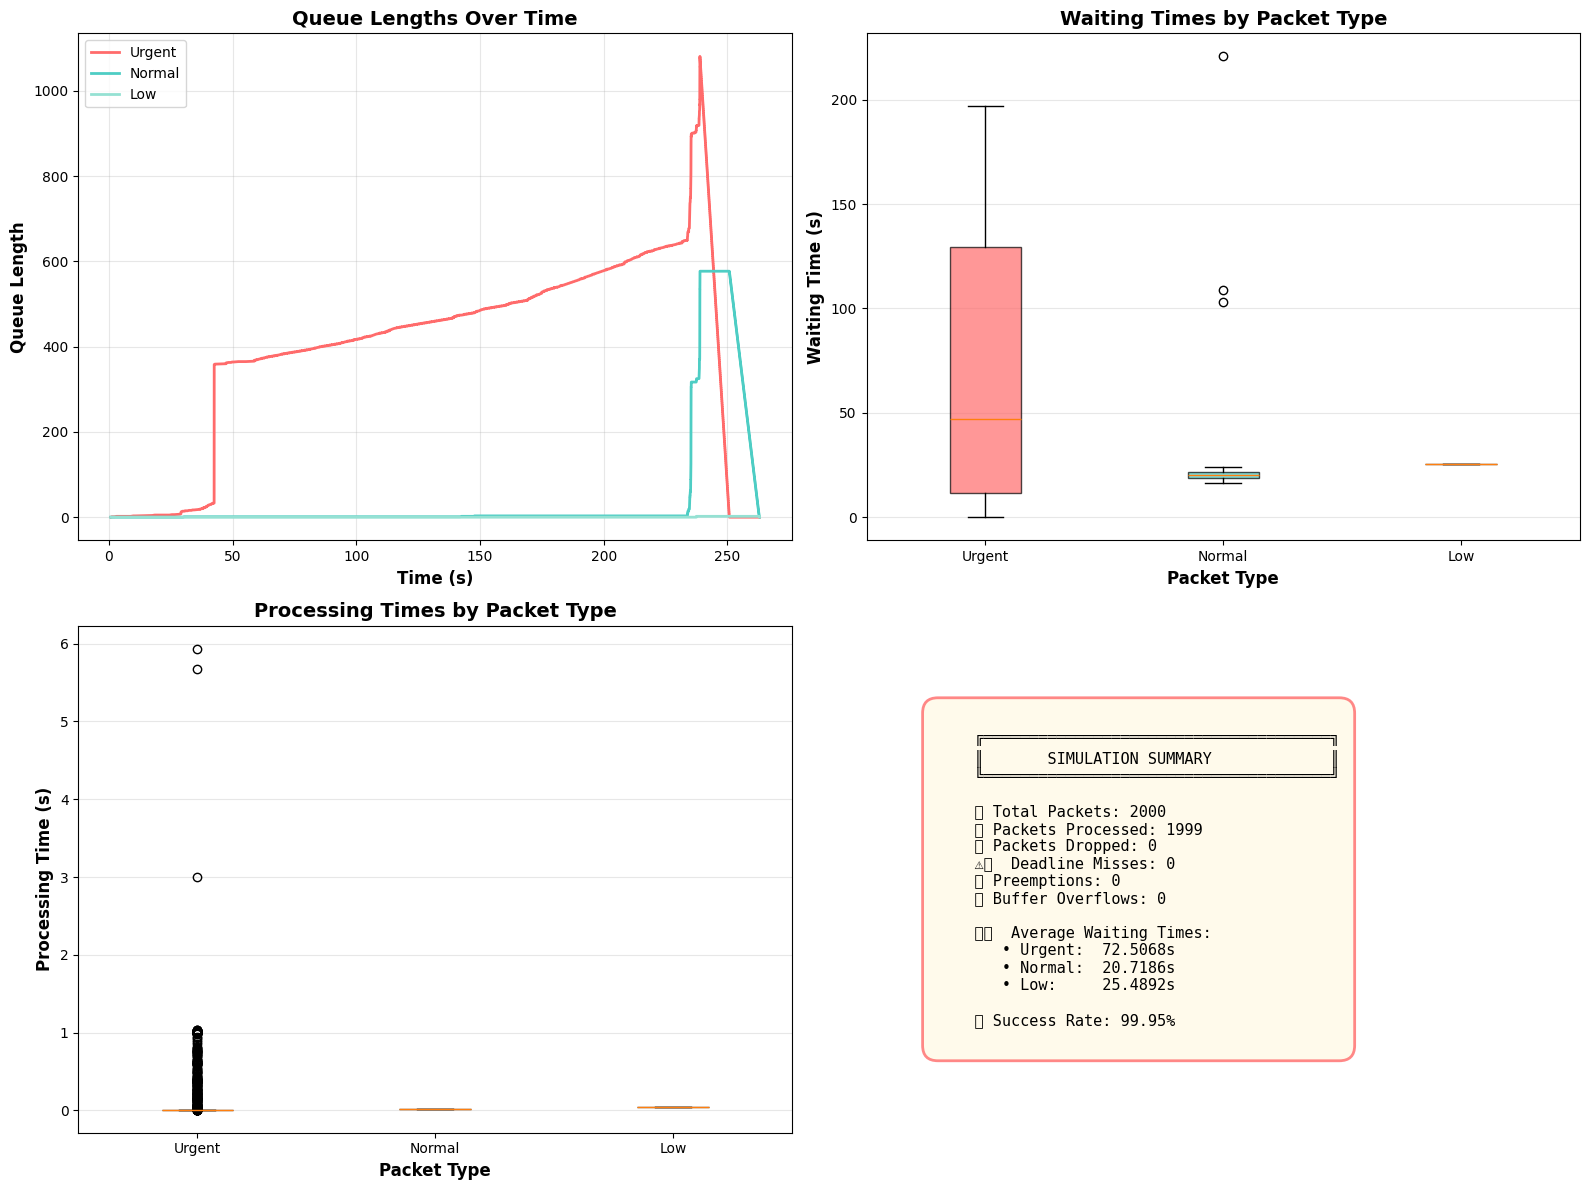

✅ Visualizations created and saved as 'simulation_results.png'!

 🎬 CREATING REAL-TIME ANIMATION

🎬 Creating animation...
Animation will show first 160.0 seconds
✅ Animation created successfully!

💾 Saving animation to scheduler_animation.mp4...
✅ Animation saved!

🎬 Displaying saved animation video...


In [ ]:
main()